In [1]:
import random
import os
import numpy as np
import sklearn
import torch
from torch.cuda import manual_seed_all
from torch import manual_seed as torch_manual_seed
from torch.backends import cudnn
import matplotlib as mpl
from matplotlib import pyplot as plt
import torchaudio
import torchaudio.transforms as T

In [2]:
# pre spectrogram augmentations
# these are examples and can be changed based on domain knowledge

def shift_pitch(waveform, sample_rate=44100, n_steps = 2):
    pitch_shift = T.PitchShift(sample_rate, n_steps)  # Shift up by 2 semitones
    return pitch_shift(waveform)

def scale_volume(waveform, factor = None):
    if factor is None:
        waveform *= torch.FloatTensor(1).uniform_(0.8, 1.5).item()  # Amplifies waveform by random factor
    else:
        waveform *= factor
    return waveform

def crop_waveform(waveform, crop_size):
    start = torch.randint(0, max(1, waveform.size(-1) - crop_size), (1,)).item()
    return waveform[:, start:start + crop_size]

def apply_reverb(waveform):
    
    return waveform

def time_shift(waveform, shift):
    return torch.roll(waveform, shifts=shift, dims=-1)

def add_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise

# Augment on-the-fly stochastically
def augment_waveform(data):
    waveform = data
    # if torch.rand(1).item() > 0.9:
    #     waveform = add_noise(waveform)
    # if torch.rand(1).item() > 0.9:
    #     waveform = time_shift(waveform, shift=torch.randint(-waveform.size(-1) // 2, waveform.size(-1) // 2, (1,)).item())
    # if torch.rand(1).item() > 0.9:
    #     waveform = scale_volume(waveform)
    # if torch.rand(1).item() > 0.9:
    #     waveform = shift_pitch(waveform, sample_rate = 22050, n_steps= int(torch.randint(-2, 2, (1,)).item()))
    return waveform

# Create a MelSpectrogram transformation
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=22050,         # Default sample rate, change if needed
    n_fft=512,                # Number of FFT bins
    hop_length=256,            # Hop length between windows
    n_mels=64                  # Number of Mel bands
)

def waveform_to_spectrogram(waveform):
    spectrogram = mel_spectrogram_transform(waveform)  # Apply the spectrogram transformation
    return spectrogram


In [3]:
# post spectrogram augmentations

# Example augmentations, could add more
time_mask = T.TimeMasking(time_mask_param=10)

freq_mask = T.FrequencyMasking(freq_mask_param=8)

# hybridizes two sounds
def mixup(spectrogram1, spectrogram2, alpha=0.2):
    lam = torch.FloatTensor(1).uniform_(0, alpha).item()
    return lam * spectrogram1 + (1 - lam) * spectrogram2

# # should probably implement a randomization process like above
# def augment_spectrogram(spectrogram):
#     augmented = time_mask(spectrogram)  # Apply time masking
#     augmented = freq_mask(augmented)   # Apply frequency masking
#     return augmented
    

In [4]:
import torchaudio.transforms as T

augment_spectrogram = T.AmplitudeToDB()

# Combine transformations into a callable function
def train_transform(waveform):
    waveform = augment_waveform(waveform)
    spectrogram = waveform_to_spectrogram(waveform)
    spectrogram = augment_spectrogram(spectrogram)
    return spectrogram

def val_transform(waveform):
    spectrogram = waveform_to_spectrogram(waveform)
    spectrogram = augment_spectrogram(spectrogram)
    return spectrogram

def pad_with_noise(spectrogram, max_time, noise_std=0.01):
    """
    Pads a spectrogram with Gaussian noise instead of zeros.

    Args:
        spectrogram (Tensor): Shape (channels, freq_bins, time_steps)
        max_time (int): Target time dimension
        noise_std (float): Standard deviation of the Gaussian noise

    Returns:
        Tensor: Padded spectrogram with noise
    """
    # Compute how much padding is needed
    pad_amount = max_time - spectrogram.size(2)
    
    if pad_amount > 0:
        # Generate random noise matching the shape of missing time steps
        noise = torch.randn((spectrogram.size(0), spectrogram.size(1), pad_amount)) * noise_std
        
        # Concatenate noise along the time axis
        spectrogram = torch.cat([spectrogram, noise], dim=2)
    
    return spectrogram

def convert_to_three_channels(spectrogram):
    # Convert [2, 224, 224] to [3, 224, 224]
    if spectrogram.size(0) == 2:
        # Calculate the mean of the two channels
        mean_channel = torch.mean(spectrogram, dim=0, keepdim=True)
        # Concatenate the mean channel as the third channel
        return torch.cat((spectrogram, mean_channel), dim=0)
    return spectrogram

In [5]:
import os
import torchaudio
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class UrbanSoundDataset(Dataset):
    def __init__(self, audio_path, fold, csv_path, transform=None):
        self.audio_path = os.path.join(audio_path, f"fold{fold}")
        self.file_list = [os.path.join(self.audio_path, f) for f in os.listdir(self.audio_path) if f.endswith(".wav")]
        self.transform = transform

        # Load the metadata CSV file
        self.metadata = pd.read_csv(csv_path)

    def get_label(self, file_name):
        """Fetch the class label for a given file name from the metadata."""
        label_row = self.metadata.loc[self.metadata['slice_file_name'] == file_name, 'class']
        if not label_row.empty:
            return label_row.values[0]
        else:
            raise ValueError(f"File name {file_name} not found in metadata CSV.")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load the audio file
        file_path = self.file_list[idx]
        waveform, sample_rate = torchaudio.load(file_path)

        # Convert mono to stereo if necessary
        if waveform.size(0) == 1:  # If mono
            waveform = waveform.repeat(3, 1)

        # Apply transformations
        if self.transform:
            waveform = self.transform(waveform)

        # Extract the file name from the path
        file_name = os.path.basename(file_path)

        # Get the corresponding label for the file
        label = self.get_label(file_name)

        return waveform, label


In [6]:
from torch.utils.data import Dataset

class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [7]:
import torchvision.transforms as transforms

def custom_collate_fn(batch):
    # Resize and normalize for DenseNet
    resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for DenseNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
    ])
    
    inputs, labels = zip(*batch)  # Separate inputs and labels
    max_time = max(spectrogram.size(2) for spectrogram in inputs)

    # Pad inputs to the same length along the time dimension
    padded_inputs = [
        pad_with_noise(input, max_time - input.size(2))
        for input in inputs
    ]

    # Convert to 3 channels and resize
    resized_inputs = [resize_transform(convert_to_three_channels(input)) for input in padded_inputs]
    
    # Map labels to numeric class IDs
    class_mapping = {
        "air_conditioner": 0,
        "car_horn": 1,
        "children_playing": 2,
        "dog_bark": 3,
        "drilling": 4,
        "engine_idling": 5,
        "gun_shot": 6,
        "jackhammer": 7,
        "siren": 8,
        "street_music": 9
    }

    numeric_labels = [class_mapping[label] for label in labels]

    # Stack inputs and labels
    return torch.stack(resized_inputs), torch.tensor(numeric_labels)


In [8]:
import torch
import torchvision
from torch import nn

class densenet(torch.nn.Module):
    """
    DenseNet Class, derived from Pytorch. Intended for model manipulation (i.e. unfreezing layers, etc.)
    To use model, try (densenet).model(data)
    May change to reflect manual implementation of densenet161.
    """
    def __init__(self, weights = "DEFAULT", drop = 0.5):
        super().__init__()  # Initialize the nn.Module base class
        self.model = torchvision.models.densenet161(weights = weights)
        
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(drop),  # Add dropout with 50% probability
            nn.Linear(num_features, 10)  # Adjust for 10 output classes (UrbanSound8k)
        )
        
        # Ensure classifier is trainable
        for param in self.model.classifier.parameters():
            param.requires_grad = True


    def forward(self, x):
        return self.model(x)  # Delegate forward pass to the original DenseNet

    def layer_change(self, layer=0):
        if layer > 0:    
            # Freeze earlier layers (optional)
            for name, param in self.model.features.named_parameters():
                if "conv0" in name or "denseblock1" in name:  # Freeze initial layers and denseblock1
                    param.requires_grad = False
        if layer > 1:    
            # Freeze earlier layers (optional)
            for name, param in self.model.features.named_parameters():
                if "denseblock2" in name:  # Freeze initial layers and denseblock2
                    param.requires_grad = False
        if layer > 2:    
            # Freeze earlier layers (optional)
            for name, param in self.model.features.named_parameters():
                if "denseblock3" in name:  # Freeze initial layers and denseblock3
                    param.requires_grad = False
        if layer > 3:    
            # Freeze earlier layers (optional)
            for name, param in self.model.features.named_parameters():
                if "denseblock4" in name:  # Freeze initial layers and denseblock4
                    param.requires_grad = False

In [9]:
# model = densenet()
# for param in model.model.features.named_parameters():
#     print(param[0])

In [10]:
# Define training and testing loops

def train_loop(train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler=None, epochs=1):
    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Store metrics
    epoch_train_losses = []  # Track training loss across epochs
    epoch_val_losses = []  # Track validation loss across epochs
    epoch_val_accuracies = []  # Track validation accuracy across epochs

    # Training loop with early stopping
    early_stopping = EarlyStopping(patience=4, min_delta=0.0005)
    
    early_stop_epoch = None
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        size = len(train_dataloader.dataset)
        total_loss = 0  # Initialize variable to accumulate training loss
        

        for batch, (X, y) in enumerate(train_dataloader):
            # Compute prediction and loss
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            total_loss += loss.item()

            # Print progress periodically
            total_batches = len(train_dataloader)
            if batch % (total_batches // 5) == 0:  # Prints 5 times per epoch
                current = (batch + 1) * len(X)
                print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

        # Average training loss for the epoch
        avg_train_loss = total_loss / len(train_dataloader)
        # print(len(train_dataloader))
        print(f"Training Loss (Epoch): {avg_train_loss:>7f}")
        epoch_train_losses.append(avg_train_loss)

        # **Validation Step**
        print("Validating...")
        avg_val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn, verbose=False)
        print(f"Validation Loss: {avg_val_loss:.6f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

        # Track validation metrics
        epoch_val_losses.append(avg_val_loss)
        epoch_val_accuracies.append(val_accuracy)

        if scheduler is not None:
            scheduler.step(val_accuracy)
            print(f"Learning Rate: {scheduler.get_last_lr()}")
        
        # Check for early stopping
        early_stopping(avg_val_loss)
        if early_stopping.stop_training:
            print("Early stopping triggered. Training stopped.")
            early_stop_epoch = epoch
            break

    # Return metrics for tracking/aggregation across folds
    return epoch_train_losses, epoch_val_losses, epoch_val_accuracies, early_stop_epoch

def test_loop(dataloader, model, loss_fn, verbose=True):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Average loss and accuracy for this fold
    avg_test_loss = test_loss / num_batches
    accuracy = correct / size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")
    return avg_test_loss, accuracy  # Return both average loss and accuracy for this fold

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait for improvement.
            min_delta (float): Minimum change in monitored value to qualify as improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.stop_training = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True   


In [12]:
print(os.getcwd())

/sfs/gpfs/tardis/home/asm2fe/UrbanAdversary


In [13]:
from sklearn.model_selection import train_test_split
import torch

# Specify paths and batch size
AUDIO_PATH = "./UrbanSound8K/audio"
CSV_PATH = "./UrbanSound8K/metadata/UrbanSound8K.csv"


def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

def dense_tune(layer = 0, lr = 2e-4, weight_decay = 0.1, weights = "DEFAULT", drop = 0.8, SEED = 666,\
     total_epochs = 20, batch_size = 70, folds = 10):
    loss_fn = torch.nn.CrossEntropyLoss()
    setup_seed(SEED)

    # Variables to accumulate metrics across folds
    fold_train_losses = []
    fold_val_losses = []
    fold_val_accuracies = []

    all_results = []

    # Loop through folds
    for fold in range(1, folds+1):
        model = densenet(weights = weights, drop = drop)
        model.layer_change(layer = layer) # freeze first conv and dense block(s) if desired

        print(f"Processing Fold {fold}")
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)
        # optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay = 0.01, momentum = 0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.2, patience=1, threshold_mode = 'abs', threshold= 0.1, min_lr=1e-6)

        # Initialize dataset and DataLoader
        # Base dataset with no transform yet (raw waveform only)
        dataset = UrbanSoundDataset(audio_path=AUDIO_PATH, fold=fold, transform=None, csv_path=CSV_PATH)

        # Split indices
        train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

        # Subsets
        raw_train_subset = torch.utils.data.Subset(dataset, train_indices)
        raw_val_subset = torch.utils.data.Subset(dataset, val_indices)

        # Wrapped subsets with separate transforms
        train_dataset = TransformSubset(raw_train_subset, transform=train_transform)
        val_dataset = TransformSubset(raw_val_subset, transform=val_transform)

        # Dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)


        # Train and validate (over multiple epochs per fold)
        epoch_train_losses, epoch_val_losses, epoch_val_accuracies, early_stop_epoch = train_loop(
            train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler, epochs=total_epochs
        )

        # Aggregate fold-level metrics (e.g., mean across all epochs)
        fold_train_losses.append(epoch_train_losses[-1])  # Last training losses
        fold_val_losses.append(epoch_val_losses[-1])        # Last validation losses
        fold_val_accuracies.append(epoch_val_accuracies[-1])  # Last validation accuracy

        # Log metrics for each epoch
        for epoch in range(len(epoch_train_losses)):
            all_results.append({
                'fold': fold,
                'epoch': epoch + 1,
                'train_loss': epoch_train_losses[epoch],
                'val_loss': epoch_val_losses[epoch],
                'val_accuracy': epoch_val_accuracies[epoch]
            })

    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)

    # Compute average metrics across folds
    mean_train_loss = sum(fold_train_losses) / len(fold_train_losses)
    mean_val_loss = sum(fold_val_losses) / len(fold_val_losses)
    mean_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)

    results_df.to_csv(f'DenseNet161_lr{lr}_l{layer}_wd{weight_decay}_drop{drop}_b{batch_size}_te{total_epochs}.csv', index=False)

    print(f"\nCross-Validation Results:")
    print(f"Avg Training Loss: {mean_train_loss:.6f}")
    print(f"Avg Validation Loss: {mean_val_loss:.6f}")
    print(f"Avg Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
    return mean_train_loss, mean_val_loss, mean_val_accuracy, results_df


In [14]:
import itertools

def dense_grid_search(param_grid):
    param_names = list(param_grid.keys())
    param_combinations = list(itertools.product(*param_grid.values()))

    best_params = None
    best_score = -float('inf')  # For maximizing validation accuracy
    all_results = []
    all_results_comp = []

    for combination in param_combinations:
        # Map combination to hyperparameters
        params = dict(zip(param_names, combination))
        print(f"Testing combination: {params}")

        # Call dense_tune with the current parameter combination
        mean_train_loss, mean_val_loss, mean_val_accuracy, run_results = dense_tune(
            layer=params["layer"],
            lr=params["lr"],
            weight_decay=params["weight_decay"],
            drop=params["drop"],
            total_epochs=params["total_epochs"],
            batch_size =params["batch_size"],
            folds = 10
        )

        # Store results
        result = {
            "params": params,
            "train_loss": mean_train_loss,
            "val_loss": mean_val_loss,
            "val_accuracy": mean_val_accuracy
        }
        all_results.append(result)

        all_results_comp.append(run_results)

        # Update best score and parameters
        if mean_val_accuracy > best_score:
            best_score = mean_val_accuracy
            best_params = params
    print(f"Best parameters were: {best_params}")
    print(f"Best score was: {best_score}")
    return best_params, best_score, all_results, all_results_comp

In [24]:
param_grid = {
    "layer": [2],              # Number of frozen layers
    "lr": [3e-4, 2e-4],       # Learning rates
    "weight_decay": [0.2, 0.15],     # Weight decay values
    "drop": [0.8],             # Dropout rates
    "total_epochs": [15],            # Total epochs
    "batch_size": [96, 64]
}

In [16]:
# showing memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-80GB. Max memory = 79.138 GB.
0.0 GB of memory reserved.


In [ ]:
best_params, best_score, all_results, all_results_comp = dense_grid_search(param_grid)

Testing combination: {'layer': 2, 'lr': 0.0003, 'weight_decay': 0.2, 'drop': 0.8, 'total_epochs': 15, 'batch_size': 96}
Processing Fold 1
Epoch 1/15
loss: 2.430789  [   96/  698]
loss: 2.149101  [  192/  698]
loss: 1.962404  [  288/  698]
loss: 1.797114  [  384/  698]
loss: 1.370595  [  480/  698]
loss: 1.200856  [  576/  698]
loss: 1.093486  [  672/  698]
loss: 1.210523  [  208/  698]
Training Loss (Epoch): 1.651859
Validating...
Validation Loss: 1.069552, Validation Accuracy: 79.43%
Learning Rate: [0.0003]
Epoch 2/15
loss: 0.978036  [   96/  698]
loss: 0.682104  [  192/  698]
loss: 0.901425  [  288/  698]
loss: 1.670089  [  384/  698]
loss: 0.688660  [  480/  698]
loss: 0.792708  [  576/  698]
loss: 0.621631  [  672/  698]
loss: 0.439184  [  208/  698]
Training Loss (Epoch): 0.846730
Validating...
Validation Loss: 0.575284, Validation Accuracy: 82.29%
Learning Rate: [0.0003]
Epoch 3/15
loss: 0.397699  [   96/  698]
loss: 0.348131  [  192/  698]
loss: 0.449344  [  288/  698]
loss: 0.4

In [ ]:
dense_tune(layer = 3, lr = 2e-4, weight_decay = 0.2, weights = "DEFAULT", drop = 0.8, batch_size = 90, total_epochs = 15)

In [ ]:
dense_tune(layer = 3, lr = 2e-4, weight_decay = 0.2, weights = "DEFAULT", drop = 0.8, batch_size = 64, total_epochs = 15)

In [20]:
# import torchaudio

# audio_path = "./UrbanSound8k/audio/fold1/137156-9-0-30.wav"
# waveform, sample_rate = torchaudio.load(audio_path)
# print(f"Shape: {waveform.shape}, Sample Rate: {sample_rate}")

In [21]:
def show_stereogram(spectrogram):
    # Convert to numpy
    spectrogram_np = spectrogram.numpy()  # Shape: (3, Freq, Time)

    # Plot left and right channels
    fig, axs = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True)

    axs[0].imshow(spectrogram_np[0], aspect='auto', origin='lower', cmap='magma')
    axs[0].set_title(f"Spectrogram - Left Channel")
    axs[0].set_ylabel("Frequency Bins")
    axs[0].set_xlabel("Time Frames")

    axs[1].imshow(spectrogram_np[1], aspect='auto', origin='lower', cmap='magma')
    axs[1].set_title(f"Spectrogram - Right Channel")
    axs[1].set_ylabel("Frequency Bins")
    axs[1].set_xlabel("Time Frames")

    axs[2].imshow(spectrogram_np[2], aspect='auto', origin='lower', cmap='magma')
    axs[2].set_title(f"Spectrogram - Mean Channel")
    axs[2].set_ylabel("Frequency Bins")
    axs[2].set_xlabel("Time Frames")

    plt.show()

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def show_triplet_spectrogram(spectrogram_tensor):
    """
    Expects a tensor of shape (3, H, W) representing the 3-channel input for DenseNet.
    Plots each channel separately.
    """
    # Convert to numpy, detach, and squeeze if necessary
    if isinstance(spectrogram_tensor, torch.Tensor):
        spectrogram_np = spectrogram_tensor.detach().cpu().numpy()
    else:
        spectrogram_np = spectrogram_tensor

    fig, axs = plt.subplots(3, 1, figsize=(8, 8), constrained_layout=True)

    for i in range(3):
        axs[i].imshow(spectrogram_np[i, :, :], aspect='auto', origin='lower', cmap='magma')
        axs[i].set_title(f"Channel {i+1}")
        axs[i].set_ylabel("Frequency")
        axs[i].set_xlabel("Time")

    plt.show()



In [23]:
from sklearn.model_selection import train_test_split
AUDIO_PATH = "./UrbanSound8K/audio"
CSV_PATH = "./UrbanSound8K/metadata/UrbanSound8K.csv"
batch_size = 64
dataset = UrbanSoundDataset(audio_path=AUDIO_PATH, fold=10, transform=transform_pipeline, csv_path=CSV_PATH)

train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

NameError: name 'transform_pipeline' is not defined

In [ ]:
print(train_dataloader)


torch.Size([64, 3, 224, 224])


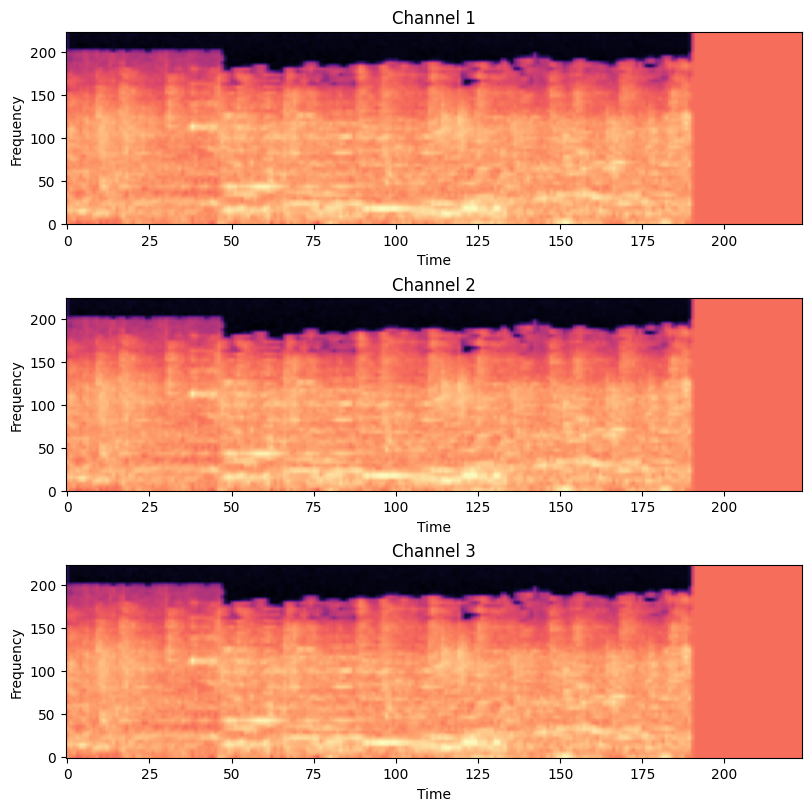

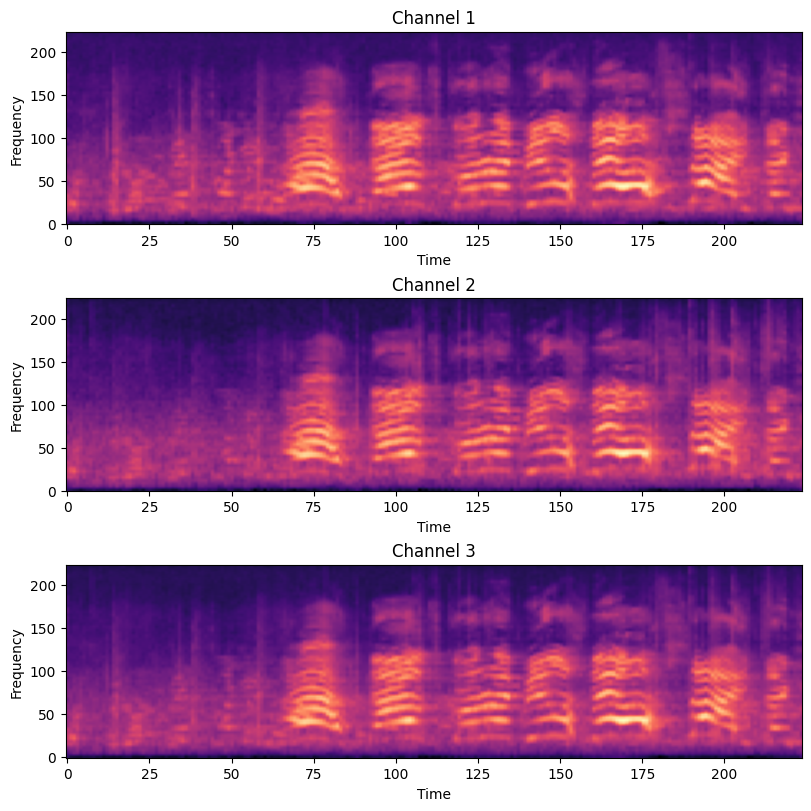

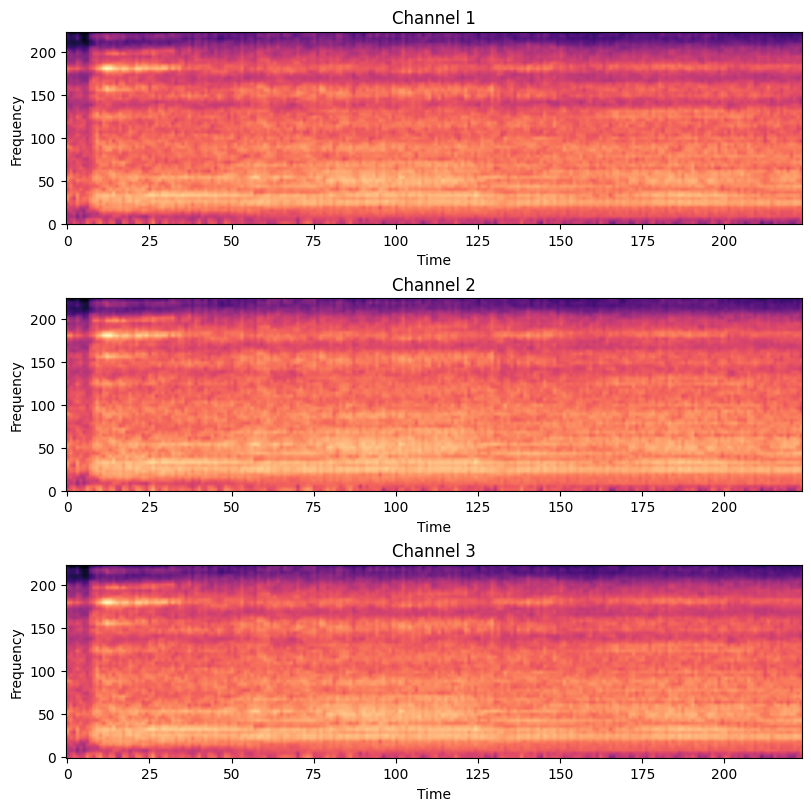

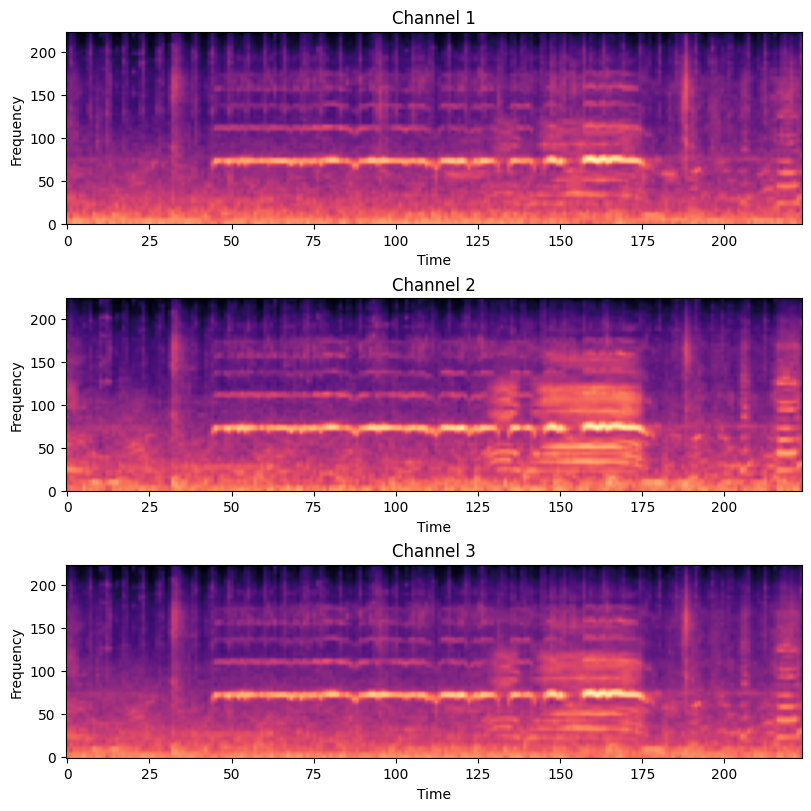

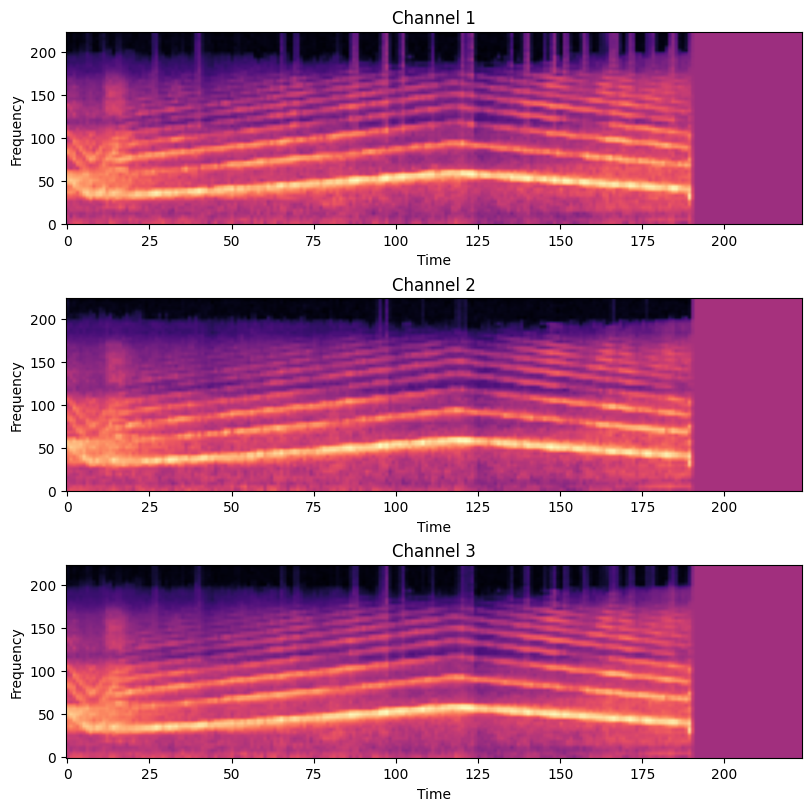

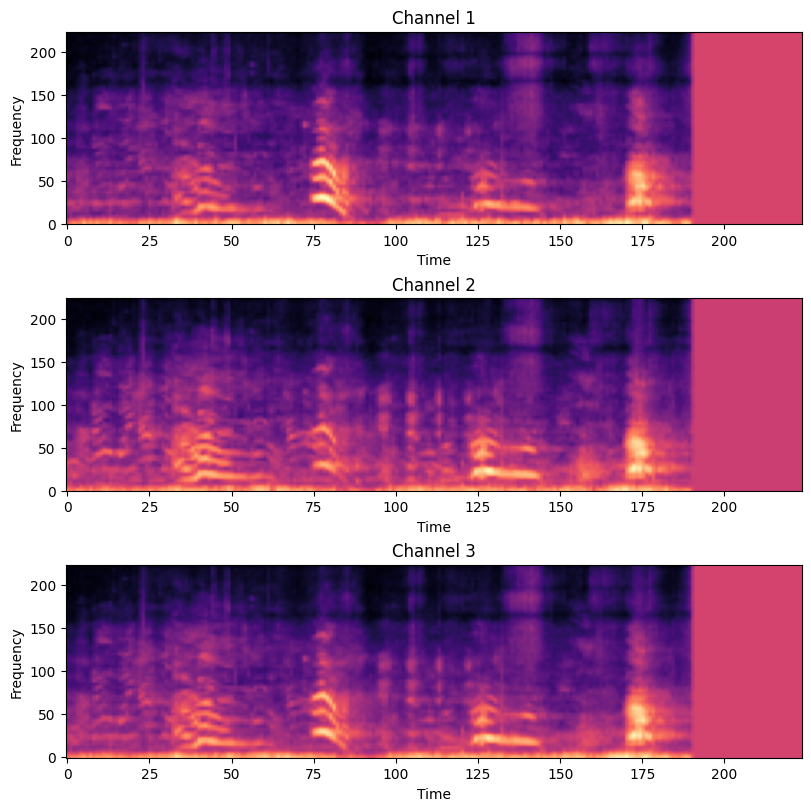

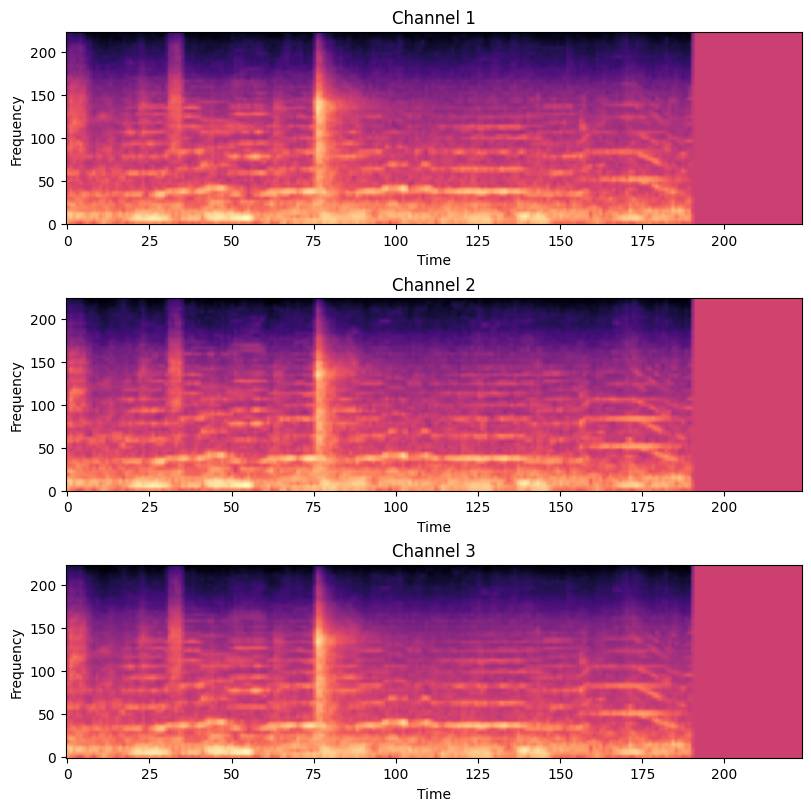

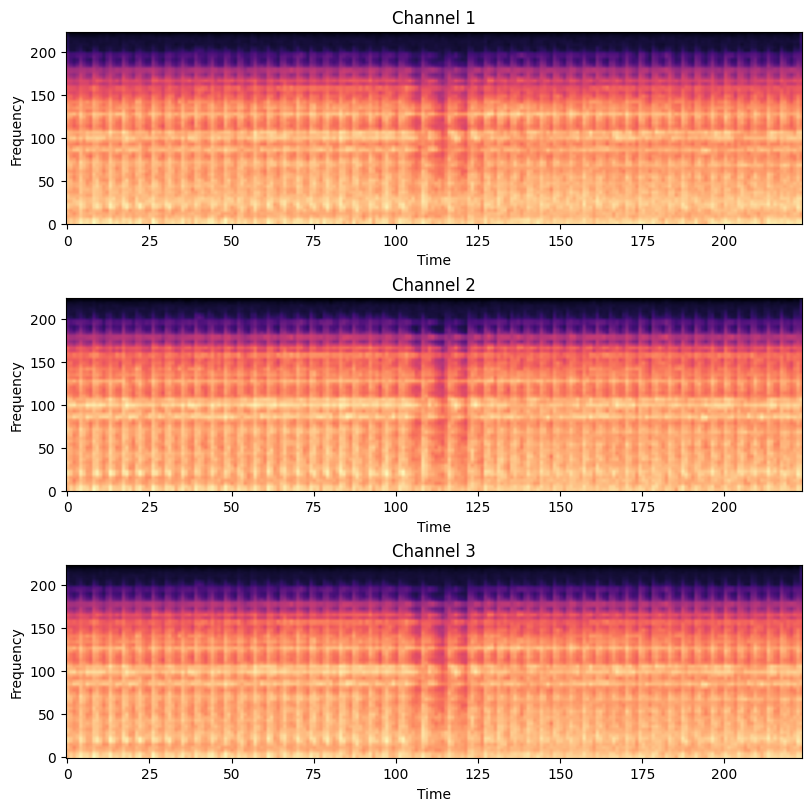

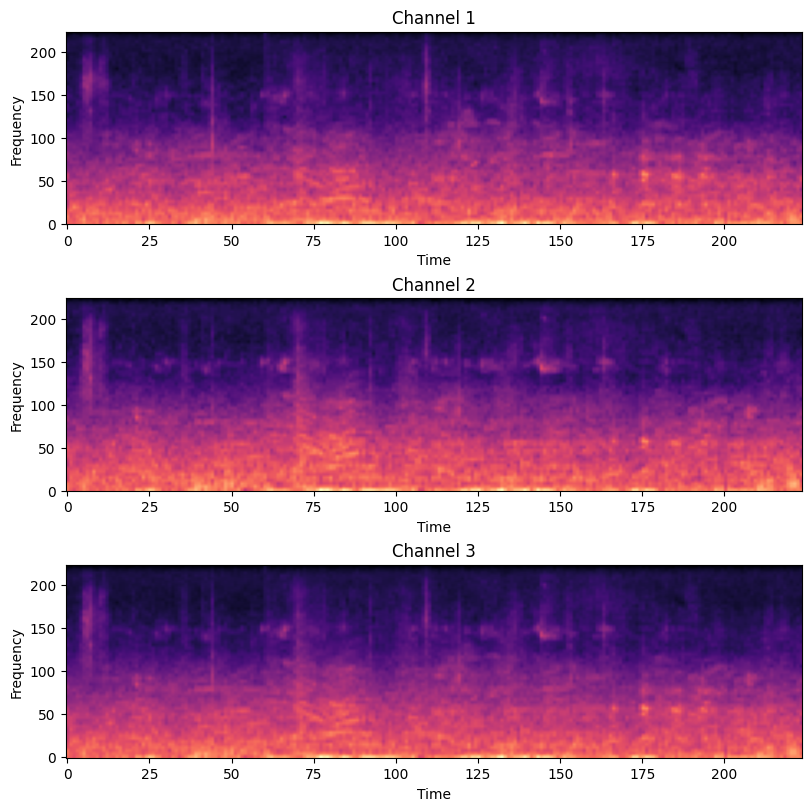

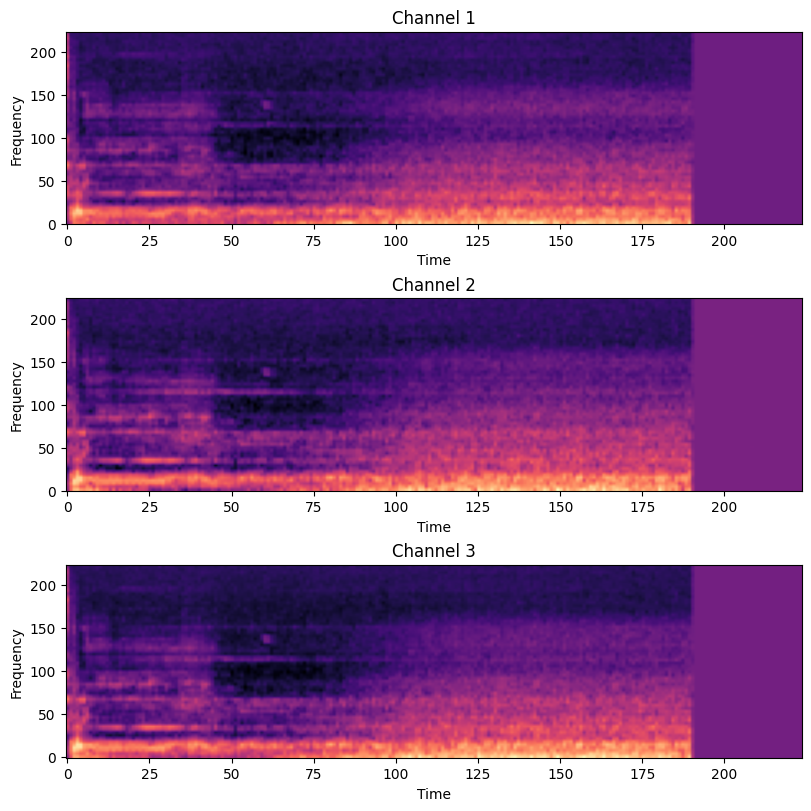

In [ ]:
for data_batch, _ in train_dataloader:  # skip labels
    print(data_batch.shape)  # (B, 3, 224, 224)
    for i in range(10,20):
        show_triplet_spectrogram(data_batch[i])

    break

